# Search-Based Test Generation - Part 2

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from inspect import signature
import inspect
import ast
import astor
import sys

We continue testing the triangle example program.

In [2]:
def triangle(a, b, c):
    if a <= 0 or b <= 0 or c <= 0:
        return 4 # invalid
    
    if a + b <= c or a + c <= b or b + c <= a:
        return 4 # invalid
    
    if a == b and b == c:
        return 1 # equilateral
    
    if a == b or b == c or a == c:
        return 2 # isosceles
    
    return 3 # scalene

## Whole Test Suite Optimisation

In Whole Test Suite Optimisation, our goal is to optimise a test suite so that it achieves the highest possible code coverage.

In [3]:
sig = signature(triangle)
num_parameters = len(sig.parameters)
num_parameters

3

In [4]:
num_tests = 30
MAX = 1000
MIN = -MAX

In [5]:
def get_random_individual():
    num = random.randint(1, num_tests)
    return [[random.randint(MIN, MAX) for _ in range(num_parameters)] for _ in range(num)]

In [6]:
get_random_individual()

[[148, -608, -458],
 [-30, -554, 352],
 [-674, 455, 71],
 [85, 991, -370],
 [45, -749, -488],
 [-466, -669, -719],
 [912, -764, -813],
 [-923, 540, 915],
 [-100, -765, 448],
 [-463, -473, 458],
 [24, -463, 36],
 [899, 689, -147],
 [761, 423, -568],
 [-863, 516, -99],
 [284, -836, -195],
 [489, 652, 342],
 [-818, -980, 965],
 [-117, 948, 651],
 [887, -612, 209],
 [-456, -139, -811],
 [-790, -156, -555],
 [-224, 641, 856],
 [899, -638, -788],
 [932, 416, 888],
 [40, 621, -32],
 [257, 31, -636],
 [378, 421, -38],
 [120, -934, -247]]

When applying mutation, we need to be able to modify individual tests as before. To keep things challenging, we will not use our optimised mutation that copies parameters, but aim to achieve the entire optimisation just using small steps:

In [7]:
def mutate_test(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = min(MAX, max(MIN, int(random.gauss(mutated[position], MAX*0.01))))
            
    return mutated

However, modifying tests is only one of the things we can do when mutating our actual individuals, which consist of multiple tests. Besides modifying existing tests, we could also delete or add tests, for example like this.

In [8]:
def mutate_set(solution):
    P_mutate = 1/len(solution)
    mutated = []
    for position in range(len(solution)):
        if random.random() >= P_mutate:
            mutated.append(solution[position][:])
            
    if not mutated:
        mutated = solution[:]
    for position in range(len(mutated)):
        if random.random() < P_mutate:
            mutated[position] = mutate_test(mutated[position])
 
    ALPHA = 1/3
    count = 1
    while random.random() < ALPHA ** count:
        count += 1
        mutated.append([random.randint(MIN, MAX) for _ in range(num_parameters)])
    
    return mutated

With a certain probability, each of the tests can be removed from a test suite; similarly, each remaining test may be mutated like we mutated tests previously. Finally, with a probability `ALPHA` we insert a new test; if we do so, we insert another one with probability `ALPHA`$^2$, and so on.

When crossing over two individuals, they might have different length, which makes choosing a crossover point difficult. For example, we might pick a crossover point that is longer than one of the parent chromosomes, and then what do we do? A simple solution would be to pick two different crossover points.

In [9]:
def variable_crossover(parent1, parent2):
    pos1 = random.randint(1, len(parent1))
    pos2 = random.randint(1, len(parent2))
    offspring1 = parent1[:pos1] + parent2[pos2:]
    offspring2 = parent2[:pos2] + parent1[pos1:]
    return (offspring1, offspring2)

Besides mutation and crossover we also require selection and elitism operators, but these are independent of the representation and therefore no different from the ones we used previously.

In [10]:
tournament_size = 3
def tournament_selection(population):
    candidates = random.sample(population, tournament_size)        
    winner = min(candidates, key = lambda x: get_fitness(x))
    return winner

In [11]:
elite_size = 2
def elitism_standard(population):
    population.sort(key = lambda k: get_fitness(k))
    return population[:elite_size]

To see this works, we need to define the fitness function. Since we want to cover _everything_ we simply need to make sure that every single branch is covered at least once in a test suite. A branch is covered if its minimum branch distance is 0; thus, if everything is covered, then the sum of minimal branch distances should be 0. In order to calculate the fitness value, we need to collect information about which branches were executed. For each condition we keep track of the branch distance for reaching the true branch and the false branch.

In [12]:
distances_true = {}
distances_false = {}

There is one special case: If an if-statement is executed only once, then optimising the true/false distance may lead to a suboptimal, oscillising evolution. We therefore also count how often each if-condition was executed. If it was only executed once, then the fitness value for that branch needs to be higher than if it was executed twice. We define a helper function `update_maps` that updates our global variables with the values observed.

In [13]:
condition_count = {}

In [14]:
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false, condition_count

    if condition_num in condition_count.keys():
        condition_count[condition_num] = condition_count[condition_num] + 1
    else:
        condition_count[condition_num] = 1
        
    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

Now we need to finish implementing the `evaluate_condition` function. We add yet another parameter to denote the ID of the branch we are instrumenting:

In [15]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0

    # Make sure the distance can be calculated on number and character
    # comparisons (needed for cgi_decode later)
    if isinstance(lhs, str):
        lhs = ord(lhs)
    if isinstance(rhs, str):
        rhs = ord(rhs)

    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Gt":
        if lhs > rhs:
            distance_false = lhs - rhs
        else:
            distance_true = rhs - lhs + 1
    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true = lhs - rhs + 1
    elif op == "LtE":
        if lhs <= rhs:
            distance_false = rhs - lhs + 1
        else:
            distance_true = lhs - rhs
    # ...
    # handle other comparison operators
    # ...

    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1
    else:
        assert False

    update_maps(num, normalise(distance_true), normalise(distance_false))

    if distance_true == 0:
        return True
    else:
        return False

We need to normalise branch distances since different comparisons will be on different scales, and this would bias the search. We will use the normalisaction function defined in the previous chapter:

In [16]:
def normalise(x):
    return x / (1.0 + x)

We also need to extend our instrumentation function to take care of all comparisons, and not just equality comparisons:

In [17]:
import ast
class BranchTransformer(ast.NodeTransformer):

    condition_num = 0

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.condition_num += 1
        return ast.Call(func=ast.Name("evaluate_condition", ast.Load()),
                        args=[ast.Num(self.condition_num - 1),
                              ast.Str(node.ops[0].__class__.__name__),
                              node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

In [18]:
source = inspect.getsource(triangle)
node = ast.parse(source)
transformer = BranchTransformer()
transformer.visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
num_conditions = transformer.condition_num

print(astor.to_source(node))

def triangle_instrumented(a, b, c):
    if evaluate_condition(0, 'LtE', a, 0) or evaluate_condition(1, 'LtE', b, 0
        ) or evaluate_condition(2, 'LtE', c, 0):
        return 4
    if evaluate_condition(3, 'LtE', a + b, c) or evaluate_condition(4,
        'LtE', a + c, b) or evaluate_condition(5, 'LtE', b + c, a):
        return 4
    if evaluate_condition(6, 'Eq', a, b) and evaluate_condition(7, 'Eq', b, c):
        return 1
    if evaluate_condition(8, 'Eq', a, b) or evaluate_condition(9, 'Eq', b, c
        ) or evaluate_condition(10, 'Eq', a, c):
        return 2
    return 3



To define an executable version of the instrumented triangle function, we introduce the`create_instrumented_function` function:

In [19]:
def create_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)

    # Compile and add the instrumented function to the current module
    current_module = sys.modules[__name__]
    code = compile(node, filename="<ast>", mode="exec")
    exec(code, current_module.__dict__)

In [20]:
create_instrumented_function(triangle)

In [21]:
triangle(4, 4, 4)

1

In [22]:
triangle_instrumented(4, 4, 4)

1

In [23]:
distances_true

{0: 0.8, 1: 0.8, 2: 0.8, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.0, 7: 0.0}

In [24]:
distances_false

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.5, 7: 0.5}

In [25]:
condition_count

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}

The actual fitness function now is the sum of minimal distances after all tests have been executed. If an if-condition was not executed at all, then the true distance and the false distance will be 1, resulting in a sum of 2 for the if-condition. If the condition was covered only once, we set the fitness to exactly 1. If the condition was executed more than once, then at least either the true or false distance has to be 0, such that in sum, true and false distances will be less than 0.

In [26]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false, condition_count
    distances_true =  {x: 1.0 for x in range(num_conditions)}
    distances_false = {x: 1.0 for x in range(num_conditions)}
    condition_count = {x:   0 for x in range(num_conditions)}

    # Run the function under test
    for test in x:
        triangle_instrumented(*test)

    # Sum up branch distances
    fitness = 0.0
    for condition in range(num_conditions):
        if condition_count[condition] == 1:
            fitness += 1
        else:
            fitness += distances_true[condition]
            fitness += distances_false[condition]

    return fitness

Before we run some experiments on this, let's make a small addition to our genetic algorithm: Since the size of individuals is variable it will be interesting to observe how this evolves. We'll captures the average population size in a separate list. Since the costs of evaluating fitness are no longer constant per individual but depend on the number of tests executed, we will also change our stopping criterion to the number of executed tests.

In [27]:
from statistics import mean

length_values = []
max_executions = 10000

def ga():
    population = [get_random_individual() for _ in range(population_size)]
    best_fitness = sys.maxsize
    tests_executed = 0
    for p in population:
        fitness = get_fitness(p)
        tests_executed += len(p)
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = p
    while tests_executed < max_executions:
        fitness_values.append(best_fitness)
        length_values.append(mean([len(x) for x in population]))
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            new_population.append(offspring1)
            new_population.append(offspring2)
            tests_executed += len(offspring1) + len(offspring2)

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = p
    print(f"Best fitness: {best_fitness}, size {len(best_solution)}")

    return best_solution

Since we now have all the operators we need in place, let's run a first experiment aiming to achieve 100% coverage on the triangle example.

In [28]:
max_executions = 500000
MAX = 1000
MIN = -MAX
P_xover = 0.7
crossover = variable_crossover
selection = tournament_selection
elitism   = elitism_standard 
mutate    = mutate_set
tournament_size = 4
population_size = 50
fitness_values = []
length_values = []
ga()

Best fitness: 1.497624703087886, size 626


[[277, -91, -589],
 [12, 79, 611],
 [-500, 896, 89],
 [300, 820, 815],
 [-398, 499, -726],
 [735, -435, -221],
 [-441, 15, -718],
 [410, 788, 874],
 [-79, -54, -836],
 [604, 140, 890],
 [-376, 219, 560],
 [310, 562, 36],
 [-472, -669, -961],
 [-829, -844, 112],
 [-832, -894, 594],
 [124, -215, 63],
 [526, -416, 847],
 [-912, -63, 17],
 [-629, -118, 436],
 [842, 138, 19],
 [-61, -366, -103],
 [785, 785, 365],
 [-469, 169, 481],
 [113, 621, -393],
 [490, -29, -528],
 [645, 373, -432],
 [-14, 808, 430],
 [384, 861, 510],
 [319, -201, 997],
 [483, -675, -72],
 [693, 337, 694],
 [-322, -960, 192],
 [-519, -638, -639],
 [124, -215, 63],
 [514, -408, 862],
 [-912, -63, 17],
 [-629, -118, 436],
 [842, 138, 19],
 [-61, -379, -111],
 [347, 199, 209],
 [-301, -617, 221],
 [-398, 499, -726],
 [166, 348, 481],
 [410, 788, 874],
 [-79, -54, -836],
 [120, 621, -393],
 [-175, 98, -613],
 [785, 785, 351],
 [-398, 499, -726],
 [166, 348, 481],
 [-441, 25, -718],
 [413, 788, 874],
 [-79, -54, -836],
 [78

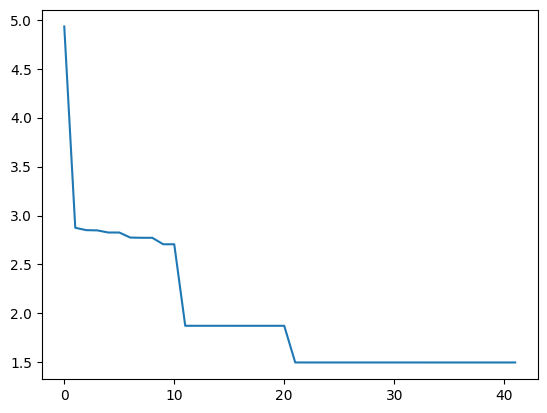

In [29]:
plt.plot(fitness_values)

The plot shows iterations of the genetic algorithm on the x-axis. Very likely, the result likely isn't great. But why? Let's look at the average population length.

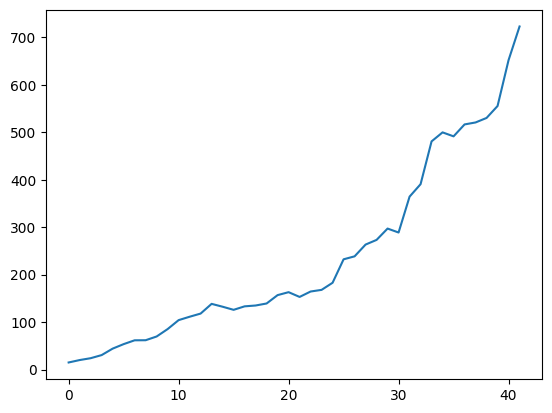

In [30]:
plt.plot(length_values)

What you can see here is a phenomenon called _bloat_: Individuals grow in size through mutation and crossover, and the search has no incentive to reduce their size (adding a test can never decrease coverage; removing a test can). As a result the individuals just keep growing, and quickly eat up all the available resources for the search.

We need to make sure that our individuals don't grow without bounds, so we adapt the other operators accordingly. When applying crossover, we pick a relative position and then cut the individuals at their relative position, such that no offspring becomes longer than the longest parent:

In [31]:
def relative_crossover(parent1, parent2):
    pos = random.random()
    pos1 = int(len(parent1) * pos)
    pos2 = int(len(parent2) * pos)
    offspring1 = parent1[:pos1] + parent2[pos2:]
    offspring2 = parent2[:pos2] + parent1[pos1:]
    return (offspring1, offspring2)

What's the influence of relative crossover?

Best fitness: 0.0, size 18


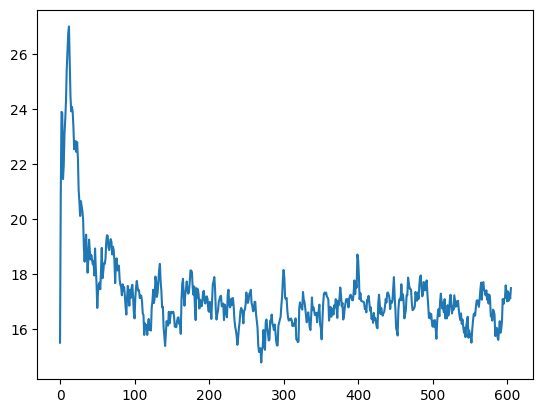

In [32]:
max_executions = 500000
MAX = 1000
MIN = -MAX
crossover = relative_crossover
selection = tournament_selection
elitism   = elitism_standard 
mutate    = mutate_set
tournament_size = 4
population_size = 50
fitness_values = []
length_values = []
ga()
plt.plot(length_values);

When selecting individuals, we apply a secondary criterion: For any two individuals with equal fitness function, we prefer the shorter one:

In [33]:
def tournament_selection_length(population, n = tournament_size):
    candidates = random.sample(population, n)        
    winner = min(candidates, key = lambda x: (get_fitness(x), len(x)))    
                
    return winner

What is the influence of length-based tournament selection?

Best fitness: 0.0, size 22


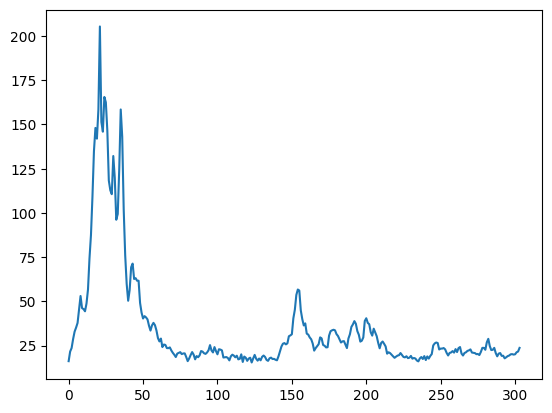

In [34]:
max_executions = 500000
MAX = 1000
MIN = -MAX
crossover = variable_crossover
selection = tournament_selection_length
elitism   = elitism_standard 
mutate    = mutate_set
tournament_size = 4
population_size = 50
fitness_values = []
length_values = []
ga()
plt.plot(length_values);

The criterion also has to hold when we apply elitism -- we don't only want the test suites with the best fitness, but we also want the smallest test suites:

In [35]:
def elitism_length(population):
    population.sort(key = lambda k: (get_fitness(k), len(k)))
    return population[:elite_size]

What is the influence of length-based elitism?

Best fitness: 1.4969879518072289, size 277


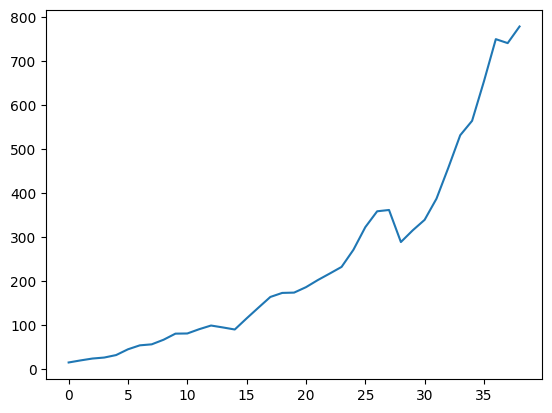

In [36]:
max_executions = 500000
MAX = 1000
MIN = -MAX
crossover = variable_crossover
selection = tournament_selection
elitism   = elitism_length 
mutate    = mutate_set
tournament_size = 4
population_size = 50
fitness_values = []
length_values = []
ga()
plt.plot(length_values);

When adding new tests during mutation, we can also ensure that the maximum size (which we set to 30 earlier) is not exceeded.

In [37]:
def mutate_bounded(solution):
    P_mutate = 1/len(solution)
    mutated = []
    for position in range(len(solution)):
        if random.random() >= P_mutate:
            mutated.append(solution[position][:])
            
    if not mutated:
        mutated = solution[:]
    for position in range(len(mutated)):
        if random.random() < P_mutate:
            mutated[position] = mutate_test(mutated[position])
 
    ALPHA = 1/3
    count = 1
    while random.random() < ALPHA ** count and len(mutated) < num_tests:
        count += 1
        mutated.append([random.randint(MIN, MAX) for _ in range(num_parameters)])
    
    return mutated

What is the influence of bounded mutation?

Best fitness: 2.15819209039548, size 315


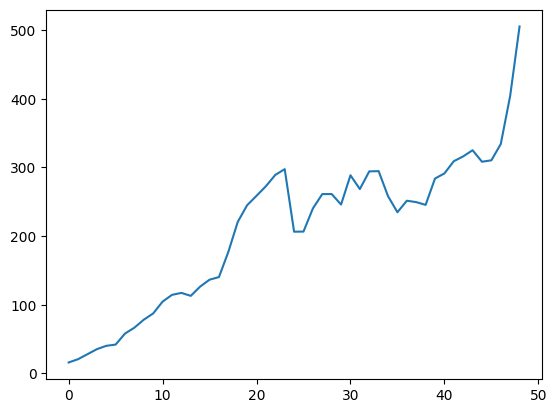

In [38]:
max_executions = 500000
MAX = 1000
MIN = -MAX
crossover = variable_crossover
selection = tournament_selection
elitism   = elitism_standard 
mutate    = mutate_bounded
tournament_size = 4
population_size = 50
fitness_values = []
length_values = []
ga()
plt.plot(length_values);

Now let's put everything together.

Best fitness: 0.0, size 13


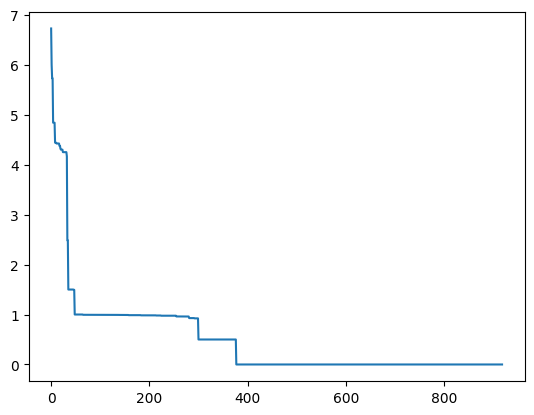

In [39]:
max_executions = 500000
MAX = 1000
MIN = -MAX
crossover = relative_crossover
selection = tournament_selection_length
elitism   = elitism_length 
mutate    = mutate_bounded
tournament_size = 4
population_size = 50
fitness_values = []
length_values = []
ga()
plt.plot(fitness_values);

The search might not always achieve 100% coverage, but note that the number of generations of the algorithm is substantially larger than in the earlier plots, and we can also see that we have contained the problem of bloat.

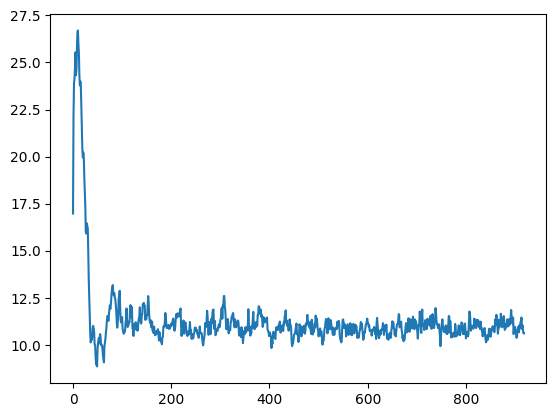

In [40]:
plt.plot(length_values)

There are some drawbacks to this approach: Once we have a test for a coverage goal, we are actually no longer interested in optimising tests for it (except for the case of minimising the overall test suite size). However, since we are optimising test suites, we always keep around all tests for all goals in the population. Usually, when you run whole test suite optimisation on our triangle example it will converge to cover most goals quickly except for the case of an equilateral triangle. Once it has reached that point the search needs to pick a test case to mutate that is not needed to satisfy another coverage goal, and then by chance mutate it such that the result is three equal sides. The chances of this happening are low, and the algorithm will not always produce 100% coverage unless waiting very long. We will therefore consider an improved approach next.

## Many-Objective Optimisation

Since we are attempting to evolve tests for multiple coverage goals, it would be tempting to use multi-objective optimisation algorithms. However, the MOEAs we have considered previously are all based on the central concept of domination. With increasing number of objectives, however, dominance becomes increasingly rare, and there are too many non-dominated individuals. For example, in a population of size 20 with NSGA-II, after combining the parent and offspring populations, if there are more than 20 non-dominated individuals, then Pareto sorting has no effect on parent selection, and there exists no selective pressure towards the Pareto front. Therefore, traditional MOEAs are usually only applied to problems with 2-3 objectives. Optimisation with more than 3 objectives are known as _many-objective_ optimisation problems. There are extensions of the MOEAs we have considered to the many objective scenario such as NSGA-III or Two Archives2:

- Deb, K., & Jain, H. (2013). An evolutionary many-objective optimization algorithm using reference-point-based nondominated sorting approach, part I: solving problems with box constraints. IEEE transactions on evolutionary computation, 18(4), 577-601.

- Wang, H., Jiao, L., & Yao, X. (2014). Two_Arch2: An improved two-archive algorithm for many-objective optimization. IEEE Transactions on Evolutionary Computation, 19(4), 524-541.

However, even such many objective optimisation algorithms can only cope with only up to ~20 objectives, whereas in test generation there can be hundreds of coverage goals to optimise for.

### MOSA

The Many-Objective Sorting Algorithm (MOSA) is an extension of the NSGA-II algorithm specifically tailored for test generation.

Panichella, A., Kifetew, F. M., & Tonella, P. (2015, April). Reformulating branch coverage as a many-objective optimization problem. In 2015 IEEE 8th international conference on software testing, verification and validation (ICST) (pp. 1-10). IEEE.


MOSA is built on NSGA-II, and includes a preference criterion: Given a branch $b$, a test case $x$ is preferred over another test case $y$ if and only if the values of the distance function $f$ for $b$ satisfy the condition $f(x) < f(y)$. This preference criterion is used to distinguish between test cases within a set of non-dominated individuals.

In order to more conveniently handle the many-objective setting let's capture the notion of coverage goals explicitly (in the previous examples this was implicitly done in the fitness function, where we only considered an individual goal or the sum of all goals):

In [41]:
class Goal:
    def __init__(self, condition, value):
        self.condition = condition
        self.value = value
    
    def get_distance(self, test):
        return test.distances[self]
    
    def is_coveredby(self, test):
        return test.distances[self] == 0
    
    def __str__(self):
        return f"Condition {self.condition}/{self.value}"

Our instrumentation gives us a number of branches, but technically, these are conditions and each condition can evaluate to true and to false, thus our coverage goals are as follows:

In [42]:
goals = [Goal(num, val) for num in range(num_conditions) for val in [True, False]]

In order to avoid redundant fitness calculations, we will also use our wrapper class to cache fitness values:

In [43]:
class L(list):
    """
    A subclass of list that can accept additional attributes.
    Should be able to be used just like a regular list.
    """
    def __new__(self, *args, **kwargs):
        return super(L, self).__new__(self, args, kwargs)

    def __init__(self, *args, **kwargs):
        if len(args) == 1 and hasattr(args[0], '__iter__'):
            list.__init__(self, args[0])
        else:
            list.__init__(self, args)
        self.__dict__.update(kwargs)

    def __call__(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

In the many objective scenario, we are back to optimising _test cases_ rather than test suites:

In [44]:
def get_random_individual():
    individual = L([random.randint(MIN, MAX) for _ in range(num_parameters)])
    evaluate(individual)
    return individual

In [45]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = L(solution[:])
    for position in range(len(solution)):
        if random.random() < P_mutate:
            if random.random() < 0.9:
                mutated[position] = min(MAX, max(MIN, int(random.gauss(mutated[position], MAX*0.01))))
            else:
                mutated[position] = random.randint(MIN, MAX)
            
    evaluate(mutated)
    return mutated

Let's also return to the regular single point crossover, since we are no longer optimising test suites, but test cases.

In [46]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = L(parent1[:pos] + parent2[pos:])
    offspring2 = L(parent2[:pos] + parent1[pos:])
    return (offspring1, offspring2)

crossover = singlepoint_crossover

We will simply use the branch distance for each of the goals again (technically, this could be refined to also include the approach level). Thus, to calculate all fitness values we need to execute a test, and store the according branch distances in a map:

In [47]:
def evaluate(individual):
    global distances_true, distances_false
    distances_true =  {x: 1.0 for x in range(num_conditions)}
    distances_false = {x: 1.0 for x in range(num_conditions)}

    triangle_instrumented(*individual)

    individual.distances = {}
    for goal in goals:
        if goal.value:
            individual.distances[goal] = distances_true[goal.condition]
        else:
            individual.distances[goal] = distances_false[goal.condition]

There are two major differences to NSGA-II now: Rather than just using the non-dominated sorted fronts directly, MOSA first applies the preference criterion to find the tests that are preferrable for the goals not yet covered. In order to keep track of which goals have already been satisfied, MOSA uses an archive to store satisfied coverage goals with the corresponding tests.

In [48]:
def update_archive(archive, population):
    
    # Ignores secondary criterion because length is fixed here
    for test in population:
        for goal in goals:
            if goal in archive:
                continue
            if goal.is_coveredby(test):
                archive[goal] = L(test[:])
                print(f"Covered goal {goal}: {test}")

The MOSA algorithm is a variation of NSGA-II. We thus need to define the regular notion of dominance, adapted to our setting with `Goals`. In contrast to NSGA-II, however, the dominance relation only looks at uncovered goals. For this, we use our archive:

In [49]:
def dominates(solution1, solution2, archive):
    for goal in goals:
        if goal in archive:
            continue # Already covered
            
        if solution1.distances[goal] > solution2.distances[goal]:
            return False

    for goal in goals:
        if goal in archive:
            continue # Already covered

        if solution1.distances[goal] < solution2.distances[goal]:
            return True

    return False

Using the dominance relation, we can apply the fast non-dominated sort algorithm we already know from NSGA-II in order to sort a population into fronts. Again we only consider uncovered goals as defined by the archive:

In [50]:
def fast_non_dominated_sort(solutions, archive):
    front = [[]]

    S = [[] for _ in range(len(solutions))]
    n = [0 for _ in range(len(solutions))]

    for p in range(len(solutions)):
        S[p] = []
        n[p] = 0
        for q in range(len(solutions)):
            if dominates(solutions[p], solutions[q], archive):
                S[p].append(q)
            elif dominates(solutions[q], solutions[p], archive):
                n[p] = n[p] + 1

        if n[p] == 0:
            front[0].append(p)
            solutions[p].rank = 0

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] = n[q] - 1
                if n[q] == 0:
                    Q.append(q)
                    solutions[q].rank = i + 1
        i = i + 1
        front.append(Q)

    del front[len(front) - 1]
    return front

As the archive can tell us which goals are covered and which are not, the prefernce sorting can focus on those individuals that are not covered yet. For each uncovered goal, the best individual is put into a special first front. All other individuals are sorted according to regular non-dominated sorting:

In [51]:
def preference_sorting(population, archive):
    # First front consists of best test per goal
    
    fronts = []
    f0 = []

    # Only consider uncovered goals
    for goal in goals:
        if goal not in archive:
            best = min(population, key=lambda t: goal.get_distance(t))
            if best not in f0:
                f0.append(best)

    for t in f0:
        t.rank = 0
    
    fronts.append(f0)
    
    remaining = [x for x in population if not x in f0]
    
    # Remaining tests: 
    if remaining:
        # Calculate non-dominance only using uncovered branches
        remaining_fronts = fast_non_dominated_sort(remaining, archive)
        for i in range(len(remaining_fronts)):
            front = [remaining[index] for index in remaining_fronts[i]]
            for t in front:
                t.rank = i + 1
            fronts.append(front)
    
    return fronts

The sorting of individuals within a front based on their crowding distance is the same we used previously, and only has to be adapted to consider our `Goal` implementation:

In [52]:
def calculate_crowding_distance_and_sort(front, archive):

    if not front:
        return
    distance = [0 for _ in range(0,len(front))]

    for goal in goals:
        if goal in archive:
            continue # Already covered

        data = [(x, front[x].distances[goal]) for x in range(len(front))]
        sorted_front = sorted(data, key=lambda tup: tup[1])
        range_fitness = sorted_front[-1][1] - sorted_front[0][1]
        if range_fitness > 0.0:
            distance[sorted_front[0][0]] = sys.maxsize
            distance[sorted_front[-1][0]] = sys.maxsize

            for k in range(1,len(front)-1):
                index = sorted_front[k][0]
                distance[index] = distance[index] + (sorted_front[k+1][1] - sorted_front[k-1][1]) / range_fitness

    for k in range(0, len(front)):
        front[k].distance = distance[k]

    front.sort(key = lambda i: i.distance, reverse=True)

Since we now have ranks based on preference sorting and we have a crowding distance, we can use the binary rank tournament selection operator we already know from NSGA-II:

In [53]:
def binary_rank_tournament(population):
    individual1 = random.choice(population)
    individual2 = random.choice(population)

    if individual1.rank < individual2.rank:
        return individual1
    elif individual1.rank > individual2.rank:
        return individual2
    else:
        return max([individual1, individual2], key = lambda i: i.distance)

Using the selection operator, we can also breed new generations:

In [54]:
def generate_offspring(population):
    offspring_population = []
    while len(offspring_population) < len(population):
        parent1 = binary_rank_tournament(population)
        parent2 = binary_rank_tournament(population)
        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2
            
        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)

        offspring_population.append(offspring1)
        offspring_population.append(offspring2)

    return offspring_population

We also need to derive the initial population:

In [55]:
def get_initial_population(archive):
    population = [get_random_individual() for _ in range(population_size)]
    update_archive(archive, population)
    fronts = preference_sorting(population, archive)
    for front in fronts:
        calculate_crowding_distance_and_sort(front, archive)

    return population

Now we have all components in place and can implement the actual algorithm, which only slightly differs from NSGA-II. The final solution is represented by the contents of the archive.

In [56]:
def mosa():
    archive = {}
    population = get_initial_population(archive)

    # TODO: Redundant?
    update_archive(archive, population)
    preference_sorting(population, archive)

    for iteration in range(max_gen):
        uncovered = sum([1 for x in goals if x not in archive])
        if uncovered > 0:
            print(f"Iteration {iteration}, missing goals: {uncovered}")

        offspring_population = generate_offspring(population)
        combined = population + offspring_population
        
        fronts = preference_sorting(combined, archive)
        population = []

        for front in fronts:
            calculate_crowding_distance_and_sort(front, archive)

            for t in front:
                population.append(t)
                if len(population) == population_size:
                    break
            if len(population) == population_size:
                break

        update_archive(archive, population)

    return archive

In [57]:
max_gen=500
MAX=10000
MIN=-MAX
result = mosa()
print(f"Covered {len(result)} out of {len(goals)} goals")
for goal, test in result.items():
    print(f"Goal {goal}: {test}")

Covered goal Condition 0/True: [-831, 7117, -6853]
Covered goal Condition 0/False: [2011, 5202, -3597]
Covered goal Condition 1/False: [2011, 5202, -3597]
Covered goal Condition 2/True: [2011, 5202, -3597]
Covered goal Condition 1/True: [5895, -6747, -4617]
Covered goal Condition 2/False: [1223, 2783, 2045]
Covered goal Condition 3/False: [1223, 2783, 2045]
Covered goal Condition 4/False: [1223, 2783, 2045]
Covered goal Condition 5/False: [1223, 2783, 2045]
Covered goal Condition 6/False: [1223, 2783, 2045]
Covered goal Condition 8/False: [1223, 2783, 2045]
Covered goal Condition 9/False: [1223, 2783, 2045]
Covered goal Condition 10/False: [1223, 2783, 2045]
Covered goal Condition 3/True: [1122, 1836, 5906]
Covered goal Condition 4/True: [772, 8043, 5870]
Iteration 0, missing goals: 7
Iteration 1, missing goals: 7
Iteration 2, missing goals: 7
Iteration 3, missing goals: 7
Iteration 4, missing goals: 7
Covered goal Condition 5/True: [7252, 1613, 2674]
Iteration 5, missing goals: 6
Iter

### MIO

The Many Independent Objective search algorithm (MIO) addresses the problem that in test generation the number of objectives can be very large, and even with MOSA it will likely not be possible to achieve 100% coverage. Instead, the search tries to focus on those goals that are most promising, given the resources available.

Arcuri, A. (2017, September). Many independent objective (MIO) algorithm for test suite generation. In International Symposium on Search Based Software Engineering (pp. 3-17). Springer, Cham.


The MIO algorithm is based on a simple (1+1)EA and maintains an archive of tests. In the archive, for each coverage goal there is a population of $n$ tests. Thus, for $z$ coverage goals there can be up to $n×z$ tests in the archive
at the same time. The archive is initially empty, and the first individual is generated randomly. Once there are tests in the archive, MIO probabilistically either samples a new random test, or chooses a test from the archive and mutates a copy of it. For each new/mutated test the fitness is calculated, and the test is added to the archive if needed.

Updating the archive with a test is based a heuristic function that is calculated for each coverage goal. If a goal is covered by a new test, then the archive for that test is replaced with that individual test. If the goal is already covered, then the existing covering test is only replaced if it is better in some other dimension (e.g. size, although that does not apply in or scenario). If the heuristic value is the worst possible value (e.g., the relevant branch predicate is not executed at all and there is no branch distance), then that test is not a candidate for the archive of that goal; else, the test is added to the archive for that goal if the maximum number of tests in that archive has not exceeded a maximum size. If the maximum size is reached, then the new test replaces the worst test in the archive, if it has a better heuristic value.

In [58]:
archive_size = 10
def update_mio_archive(archive, t):
    for goal in goals:
        if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
            # Goal is already covered
            continue
        h = goal.get_distance(t)
        if h == 0:
            # Keep only that test, remove all others            
            print(f"Goal {goal} covered by {t}")
            archive[goal] = [t]

        elif h < 1:
            if goal not in archive:
                archive[goal] = [t]
            elif len(archive[goal]) < archive_size and not t in archive[goal]:
                archive[goal].append(t)
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                archive[goal].append(t)
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))

When sampling a test from the archive in order to produce a new offspring, the algorithm first randomly selects an uncovered goal, and then randomly selects a test for that goal from the archive. If the archive contains no tests for uncovered goals, then it randomly selects a covered goal and uses that test.

In [59]:
def sample_archive(archive):
    uncovered_goals = []
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            continue
        elif len(tests) > 0:
            uncovered_goals.append(goal)
            
    if not uncovered_goals:
        for goal, tests in archive.items():
            if len(tests) > 0:
                uncovered_goals.append(goal)
                
    goal = random.choice(uncovered_goals)
    
    # Now choose one test randomly for "goal" in archive
    return random.choice(archive[goal])

As a further improvement of the sampling process, MIO implements feedback directed sampling: The idea is that goals for which we recently achieved an improvement should be preferred, since there is potential to reach a test there, whereas goals for which no improvement has recently been achieved are either difficult or infeasible, and should thus be postponed until the easier targets have been covered. To achieve this, we add a `sample_counter` which counts how often sampling was applied to each goal. Whenever a new test for a goal is added to the archive, the counter is reset to 0. Then, we can rank the goals by their counter, and choose the goal with the lowest counter. To integrate the counter, we need to update our `update_archive` function. While making this change, we also keep track if the archive has been changed, which we will need later:

In [60]:
sample_counter = {}

In [61]:
archive_size = 10
def update_mio_archive(archive, t):
    updated = False
    for goal in goals:
        if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
            # Goal is already covered
            continue
        h = goal.get_distance(t)
        if h == 0:
            # Keep only that test, remove all others            
            print(f"Goal {goal} covered by {t}")
            sample_counter[goal] = 0
            archive[goal] = [t]
            updated = True

        elif h < 1:
            if goal not in archive:
                sample_counter[goal] = 0
                archive[goal] = [t]
                updated = True
            elif len(archive[goal]) < archive_size and not t in archive[goal]:
                sample_counter[goal] = 0
                updated = True
                archive[goal].append(t)
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                sample_counter[goal] = 0
                archive[goal].append(t)
                updated = True
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))
            
    return updated

Accordingly, we can now update the sampling method to consider the counter:

In [62]:
def sample_archive(archive):
    uncovered_goals = []    
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            continue
        elif len(tests) > 0:
            uncovered_goals.append(goal)
            
    if not uncovered_goals:        
        for goal, tests in archive.items():            
            if len(tests) > 0:
                uncovered_goals.append(goal)
    
    # Shuffle first such that in the case of ties
    # we still have some variation
    random.shuffle(uncovered_goals)
    uncovered_goals.sort(key = lambda g: sample_counter[g])

    goal = uncovered_goals[0]
    sample_counter[goal] += 1
    
    # Now choose one test randomly for "goal" in archive
    return random.choice(archive[goal])

At the end of the search, for each goal which has exactly one test in the archive and that test covers the goal, this test is part of the resulting test suite:

In [63]:
def get_solutions(archive):
    test_suite = {}
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            test_suite[goal] = tests[0]
    return test_suite

The algorithm itself is now very simple:

In [64]:
P_sample = 0.5

def mio():
    archive = {}
    
    for step in range(max_gen * population_size):
        if random.random() < P_sample or len(archive) == 0:
            current = get_random_individual()
        else:
            current = sample_archive(archive)
            current = mutate(current)

        update_mio_archive(archive, current)
        
    return get_solutions(archive)
    

In [65]:
sample_counter = {}
result = mio()
print(f"Covered {len(result)}/{len(goals)} goals")
for goal, test in result.items():
    print(f"Goal {goal}: {test}")

Goal Condition 0/True covered by [-2565, 7706, 9421]
Goal Condition 0/False covered by [5462, -2060, -3341]
Goal Condition 1/True covered by [5462, -2060, -3341]
Goal Condition 1/False covered by [8009, 9486, -7336]
Goal Condition 2/True covered by [8009, 9486, -7336]
Goal Condition 2/False covered by [670, 455, 4018]
Goal Condition 3/True covered by [670, 455, 4018]
Goal Condition 3/False covered by [4873, 6562, 5476]
Goal Condition 4/False covered by [4873, 6562, 5476]
Goal Condition 5/False covered by [4873, 6562, 5476]
Goal Condition 6/False covered by [4873, 6562, 5476]
Goal Condition 8/False covered by [4873, 6562, 5476]
Goal Condition 9/False covered by [4873, 6562, 5476]
Goal Condition 10/False covered by [4873, 6562, 5476]
Goal Condition 5/True covered by [8994, 1626, 3874]
Goal Condition 4/True covered by [741, 8908, 943]
Goal Condition 6/True covered by [6445, 6445, 2971]
Goal Condition 7/False covered by [6445, 6445, 2971]
Goal Condition 8/True covered by [6445, 6445, 2971]

As a further refinement, MIO can take into account that, during initial phases of the search more exploration is generally needed, while later phases should focus on exploitation. More exploration means that the probability of sampling a new, random test should be higher, while focusing on exploitation would reduce that probability and focus on improving fewer existing individuals, thus also reducing the archive size. MIO therefore defines two sets of parameters: The probability of sampling new tests, the size of the archive, and the number of mutations applied to the same individual with their initial values, and their values once the focused phase begins:

In [66]:
P_sample_focused = 0
P_sample_first = 0.5

archive_size_focused = 1
archive_size_first = 10

mutations_focused = 10
mutations_first = 1

# Percentage of search budget spent when focused phase should begin
F = 0.5

From the initial phase to the beginning of the focused phase, the parameters are gradually moved towards their focused values:

In [67]:
focused = False
def update_parameters(steps, archive):
    global focused, P_sample, archive_size, num_mutations, F
    progress = steps / (max_gen * population_size)
    progress_until_focused = progress / F;
    if progress > F:
        P_sample = P_sample_focused
        archive_size = archive_size_focused
        num_mutations = mutations_focused
        if not focused:
            print(f"Entering focused phase")
            focused = True
    else:
        pps = P_sample
        pas = archive_size
        pnm = num_mutations
        
        P_sample = P_sample_first + (P_sample_focused - P_sample_first) * progress_until_focused
        archive_size = int(archive_size_first + (archive_size_focused - archive_size_first) * progress_until_focused)
        num_mutations = int(mutations_first + (mutations_focused - mutations_first) * progress_until_focused)
        
        if pas != archive_size:
            # Crop archives if necessary
            for goal in goals:
                if goal in archive:
                    while len(archive[goal]) > archive_size:
                        # Delete worst
                        del archive[goal][-1]

The updated MIO algorithm needs to update the parameters, and also consider the case that the current individual can be mutated multiple times:

In [68]:
import copy
P_sample = 0.7
archive_size = 10
num_mutations = 1
F = 0.5
def mio():
    sample_counter = {}
    archive = {}
    update_parameters(0, archive)
    current_mutations = 0
    current = None
    
    for step in range(max_gen * population_size):
        if current and current_mutations < num_mutations:
            offspring = mutate(current)
            current_mutations += 1
        elif random.random() < P_sample or len(archive) == 0:
            offspring = get_random_individual()
            current_mutations = 1
        else:
            offspring = sample_archive(archive)
            offspring = mutate(offspring)
            current_mutations = 1

        update_parameters(step, archive)
        result = update_mio_archive(archive, offspring)
        if result:
            current = copy.deepcopy(offspring)
        
    return get_solutions(archive)

In [69]:
sample_counter = {}
focused = False
result = mio()
print(f"Covered {len(result)}/{len(goals)} goals")
for goal, test in result.items():
    print(f"Goal {goal}: {test}")

Goal Condition 0/True covered by [-2621, -6126, 8832]
Goal Condition 0/False covered by [3255, 9435, 76]
Goal Condition 1/False covered by [3255, 9435, 76]
Goal Condition 2/False covered by [3255, 9435, 76]
Goal Condition 3/False covered by [3255, 9435, 76]
Goal Condition 4/True covered by [3255, 9435, 76]
Goal Condition 1/True covered by [2648, -6455, -3199]
Goal Condition 3/True covered by [1819, 675, 9227]
Goal Condition 4/False covered by [2526, 2759, 2901]
Goal Condition 5/False covered by [2526, 2759, 2901]
Goal Condition 6/False covered by [2526, 2759, 2901]
Goal Condition 8/False covered by [2526, 2759, 2901]
Goal Condition 9/False covered by [2526, 2759, 2901]
Goal Condition 10/False covered by [2526, 2759, 2901]
Goal Condition 2/True covered by [2839, 4574, -2354]
Goal Condition 5/True covered by [6573, 2131, 1453]
Goal Condition 6/True covered by [2751, 2751, 2544]
Goal Condition 7/False covered by [2751, 2751, 2544]
Goal Condition 8/True covered by [2751, 2751, 2544]
Goal C

### Evaluation

The hypervolume is less suitable to evaluate the results of these algorithms -- in MIO we don't have an explicit Pareto front, and even though in MOSA we do have a first front, test cases that do not quite cover a coverage goal are of no practical use. The metric we therefore consider is the number of coverage goals satisfied. For our implementations of MIO and MOSA we can see this number from the number of tests in a test suite.

In [70]:
from IPython.utils import io

def run_times(algorithm, repetitions):
    global fitness_values, diversity_values, ims
    result = []
    for i in range(repetitions):
        with io.capture_output() as captured: 
            testsuite = algorithm()
        result.append(len(testsuite) / len(goals))
    return result

Let's increase the difficulty of the search problem somewhat so we can actually see some differences:

In [71]:
MAX=1000000
MIN=-MAX

[Text(1, 0, 'MIO'), Text(2, 0, 'MOSA')]

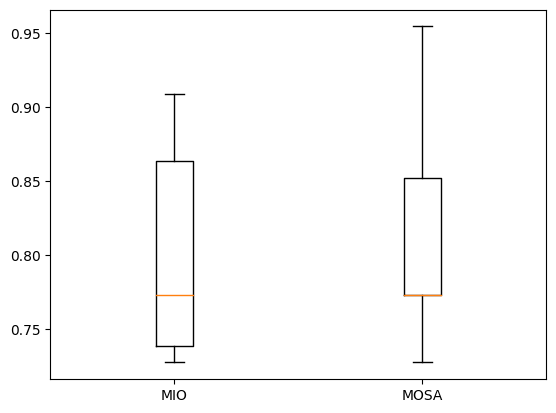

In [72]:
results = {"MIO"  : run_times(mio, 10), 
           "MOSA" : run_times(mosa, 10)}
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

### Variable Length Tests

The `cgi_decode()` function originates in the book _Pezzè, M., & Young, M. (2008). Software testing and analysis: process, principles, and techniques. John Wiley & Sons._, and we will use the Python implementation used in the [Fuzzingbook](https://www.fuzzingbook.org/). It takes as input a string using the CGI encoding common for HTTP-Get queries, and returns a decoded string.

In [73]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

In [74]:
cgi_decode("Hello")

'Hello'

In [75]:
cgi_decode("Hello+World")

'Hello World'

In [76]:
cgi_decode("Hello+World%21")

'Hello World!'

As usual, we can apply the source transformation to calculate our branch distances and determine the total number of goals:

In [77]:
source = inspect.getsource(cgi_decode)
node = ast.parse(source)
transformer = BranchTransformer()
transformer.visit(node)
node = ast.fix_missing_locations(node)
num_conditions = transformer.condition_num
print(astor.to_source(node))

def cgi_decode_instrumented(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""
    hex_values = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
        '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14,
        'f': 15, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15}
    t = ''
    i = 0
    while evaluate_condition(0, 'Lt', i, len(s)):
        c = s[i]
        if evaluate_condition(1, 'Eq', c, '+'):
            t += ' '
        elif evaluate_condition(2, 'Eq', c, '%'):
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if evaluate_condition(3, 'In', digit_high, hex_values
                ) and evaluate_condition(4, 'In', digit_low, hex_values):
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:


In [78]:
create_instrumented_function(cgi_decode)

In [79]:
goals = [Goal(num, val) for num in range(num_conditions) for val in [True, False]]
len(goals)

10

In order to apply search to this problem, we first need to update our `evaluate` function so that it calls `cgi_decoded_instrumented`. We also need to take into account that calling the function may throw an exception:

In [80]:
def evaluate(individual):
    global distances_true, distances_false
    distances_true =  {x: 1.0 for x in range(num_conditions)}
    distances_false = {x: 1.0 for x in range(num_conditions)}

    try:
        cgi_decode_instrumented(''.join(individual))
    except:
        pass

    individual.distances = {}
    for goal in goals:
        if goal.value:
            individual.distances[goal] = distances_true[goal.condition]
        else:
            individual.distances[goal] = distances_false[goal.condition]

Now we need to decide on a representation. A simple way to encode strings is as a list of characters; this way, we don't need to make many changes to our existing operators. As another modification, we restrict the range to printable characters. However, what length should we use for our tests? If we fix the length, then we might end up with redundantly long strings. Therefore, let's use a variable size representation:

In [81]:
string_length = 10
def get_random_individual():
    s = []
    length = random.randint(1, string_length)
    for i in range(string_length):
        s.append(chr(random.randrange(32, 127)))
    individual = L(s)

    evaluate(individual)
    return individual

In [82]:
def mutate(solution):
    P_mutate = 1/len(solution) if solution else 0
    result = []
    for position in range(len(solution)):
        if random.random() > P_mutate:
            result.append(solution[position])
    for position in range(len(result)):
        if random.random() < P_mutate:
            result[position] = chr(int(random.gauss(ord(result[position]), 100) % 65536))
    ALPHA = 0.1
    count = 1
    while random.random() < ALPHA ** count and len(result) < string_length:
        count += 1
        pos = random.randint(0, len(result))
        result.insert(pos, chr(random.randrange(32, 127)))
            
    mutated = L(result)
    evaluate(mutated)
    return mutated

MOSA and MIO both allow for secondary optimisation criteria: If we have already covered a test goal but have now found a new test that is shorter, we can replace the existing test in the archive. We thus need to update the archive updating functions of both algorithms to take this into account:

In [83]:
def update_archive(archive, population):
    
    for test in population:
        for goal in goals:
            if goal.is_coveredby(test):
                if not goal in archive or len(test) < len(archive[goal]):
                    archive[goal] = L(test[:])
                    print(f"Covered goal {goal}: {test}")

In [84]:
def update_mio_archive(archive, t):
    updated = False
    for goal in goals:
        h = goal.get_distance(t)
        if h == 0:
            if not goal in archive or not goal.is_coveredby(archive[goal][0]):
                print(f"Goal {goal} covered by {t}: {goal in archive}")
                sample_counter[goal] = 0
                archive[goal] = [t]
                updated = True
            elif goal.is_coveredby(archive[goal][0]):
                # Goal is already covered
                if len(t) < len(archive[goal][0]):
                    sample_counter[goal] = 0
                    archive[goal] = [t]
                    updated = True

        elif h < 1:
            if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
                # Goal is already covered
                continue
            if goal not in archive:
                sample_counter[goal] = 0
                archive[goal] = [t]
                updated = True
            elif len(archive[goal]) < archive_size and not t in archive[goal]:
                sample_counter[goal] = 0
                updated = True
                archive[goal].append(t)
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                sample_counter[goal] = 0
                archive[goal].append(t)
                updated = True
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))
            
    return updated

Without any further changes, we can now apply MOSA and MIO on this test generation problem:

In [85]:
result = mio()
print(len(result))
for goal, test in result.items():
    print(f"Goal {goal}: {''.join(test)}")

Goal Condition 0/True covered by ['=', '7', 'd', '{', '3', '0', 'Z', 'n', 'X', '?']: False
Goal Condition 0/False covered by ['=', '7', 'd', '{', '3', '0', 'Z', 'n', 'X', '?']: False
Goal Condition 1/False covered by ['=', '7', 'd', '{', '3', '0', 'Z', 'n', 'X', '?']: False
Goal Condition 2/False covered by ['=', '7', 'd', '{', '3', '0', 'Z', 'n', 'X', '?']: False
Goal Condition 2/True covered by ['@', ')', ']', '-', 'M', 'f', '9', '%', '!', 'd']: True
Goal Condition 3/False covered by ['@', ')', ']', '-', 'M', 'f', '9', '%', '!', 'd']: False
Goal Condition 1/True covered by [']', '?', '/', '.', '+', 'T', 'n', 'V', 'n', 'X']: True
Goal Condition 3/True covered by ['o', ']', '%', '6', 'g', 'X', 'v', '-', 'f', '>']: True
Goal Condition 4/False covered by ['o', ']', '%', '6', 'g', 'X', 'v', '-', 'f', '>']: False
Goal Condition 4/True covered by ['5', 'k', '|', 'H', '%', '0', 'f', 'I', 't', 'e']: True
10
Goal Condition 0/True: Ñ
Goal Condition 0/False: 
Goal Condition 1/True: +
Goal Condit

In [86]:
result = mosa()
print(len(result))
for goal, test in result.items():
    print(f"Goal {goal}: {''.join(test)}")

Covered goal Condition 0/True: ['B', 'A', 'b', 'a', ')', '}', 't', 'U', 'e', 'G']
Covered goal Condition 0/False: ['B', 'A', 'b', 'a', ')', '}', 't', 'U', 'e', 'G']
Covered goal Condition 1/False: ['B', 'A', 'b', 'a', ')', '}', 't', 'U', 'e', 'G']
Covered goal Condition 2/False: ['B', 'A', 'b', 'a', ')', '}', 't', 'U', 'e', 'G']
Covered goal Condition 1/True: ['x', '+', 'e', ':', 'R', 'O', 'j', 'b', 'w', '-']
Covered goal Condition 2/True: ['Q', '+', 'R', '_', '4', '%', '5', 'Q', '-', 'a']
Covered goal Condition 3/True: ['Q', '+', 'R', '_', '4', '%', '5', 'Q', '-', 'a']
Covered goal Condition 4/False: ['Q', '+', 'R', '_', '4', '%', '5', 'Q', '-', 'a']
Iteration 0, missing goals: 2
Covered goal Condition 0/True: ['Q', '+', '_', '4', '%', 'Q', 'ª']
Covered goal Condition 1/True: ['Q', '+', '_', '4', '%', 'Q', 'ª']
Covered goal Condition 1/False: ['Q', '+', '_', '4', '%', 'Q', 'ª']
Covered goal Condition 2/True: ['Q', '+', '_', '4', '%', 'Q', 'ª']
Covered goal Condition 2/False: ['Q', '+'

In the final test suites, there should be tests containing the character `+`, there should be invalid hex codes, valid hexcodes, and some non-escaped characters. There will be some redundancy in the overall test suite: The same test may cover multiple goals. Minimising the final test suite further, however, is another optimisation problem.